# Stability
the stability of NODE, ANODE

# generate the data and import the nessasery package

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import numpy 
device = torch.device('cpu')
from experiments.dataloaders import ConcentricSphere
from torch.utils.data import DataLoader
from viz.plots import single_feature_plt


# Create training data in 2D, consisting of a concentric disk and an annulus
data_dim = 2
data_concentric = ConcentricSphere(data_dim, inner_range=(0., .5), outer_range=(1., 1.5), 
                                   num_points_inner=1000, num_points_outer=2000)
dataloader = DataLoader(data_concentric, batch_size=64, shuffle=True)

# Visualize a batch of data (use a large batch size for visualization)
dataloader_viz = DataLoader(data_concentric, batch_size=256, shuffle=True)
for inputs, targets in dataloader_viz:
    break
from anode.models import ODENet
from anode.training import Trainer


hidden_dim = 32
num_epochs = 24
from viz.plots import trajectory_plt

# To make the plot clearer, we will use a smaller batch of data
for small_inputs, small_targets in dataloader:
    break

    
data_concentric2 = ConcentricSphere(data_dim, inner_range=(0., .5), outer_range=(1., 1.5), 
                                   num_points_inner=100, num_points_outer=200)
dataloader2 = DataLoader(data_concentric2, batch_size=64, shuffle=True)
dataloader_viz2 = DataLoader(data_concentric2, batch_size=256, shuffle=True)
for test_inputs, test_targets in dataloader_viz2:
    break

from viz.plots import input_space_plt

In [220]:
def relu_deri(x):
    for i in range(len(x)):
        if x[i] > 0 :
            x[i]= 1
        else :
            x[i]=0
    return x

def lyapunov(model,inputs,multi=True,activation='relu',plot=False):
    import numpy
    from torchdiffeq import odeint 
    import matplotlib.pyplot as plt
    level=model.odeblock.level
    if multi == False:
        inputs=inputs.view(1,inputs.shape[0])
       
    
    if model.augment_dim>0 and plot == False:        
        aug = torch.zeros(inputs.shape[0], model.augment_dim)
        inputs = torch.cat([inputs, aug],1)
        
    res=[]
    if level == 2:
        K2=model.odeblock.odefunc.fc2.weight.detach().numpy()
        b2=model.odeblock.odefunc.fc1.bias.detach().numpy()
        K=model.odeblock.odefunc.fc1.weight.detach().numpy()
        b=model.odeblock.odefunc.fc1.bias.detach().numpy()

    elif level == 1:
        K=model.odeblock.odefunc.fc1.weight.detach().numpy()
        b=model.odeblock.odefunc.fc1.bias.detach().numpy()

    buf=model.odeblock.odefunc.fc1(inputs).detach().numpy()
    if activation=='relu':
        for i in range(inputs.shape[0]):
            x=buf[i,:]
            d=numpy.diag(relu_deri(x))
            if level == 2:
                a,b=numpy.linalg.eig(numpy.dot(numpy.dot(K2,d),K))
                
            elif level == 1:
                a,b=numpy.linalg.eig(numpy.dot(d,K))
            res.append(numpy.max(a.real))
    return res



In [221]:
lyapunov(model2,small_inputs)


[0.6219461,
 1.584081,
 0.6518137,
 -0.1002737,
 5.3427467,
 0.66281265,
 1.4501919,
 0.559349,
 0.17046699,
 0.66281265,
 0.37868857,
 0.66281265,
 0.17046699,
 0.6219461,
 -0.6711731,
 1.2890443,
 0.6763368,
 0.79291815,
 0.54232854,
 0.740855,
 0.33952746,
 0.86805385,
 0.7900115,
 3.686911,
 0.0376284,
 0.86805385,
 0.12460005,
 0.86805385,
 0.58935684,
 2.8421268,
 0.5000271,
 -0.06649183,
 0.74837255,
 0.5770765,
 5.306678,
 0.11306243,
 5.306678,
 0.58935684,
 0.37868857,
 0.12460005,
 0.86805385,
 -0.5127213,
 0.6763368,
 0.58935684,
 0.6219461,
 0.12460005,
 0.34339145,
 0.58935684,
 0.15799874,
 0.17923114,
 5.3427467,
 1.4758964,
 0.12460005,
 0.67114496,
 0.74837255,
 2.1181111,
 0.6219461,
 0.34339145,
 0.12460005,
 -0.5127213,
 0.86805385,
 0.01580602,
 0.86805385,
 0.17046699]

In [296]:

def lyapunov_plot(model, plot_range=(-2., 2.), num_steps=201,activation='relu',time=0,steps=10):
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.patches import FancyArrowPatch
    from mpl_toolkits.mplot3d import Axes3D, proj3d
    from torchdiffeq import odeint 
    
    integration_time = torch.linspace(0., model.final_time, steps)
    # Grid the input space
    grid = torch.zeros((num_steps * num_steps, 2))
    idx = 0
    for x1 in np.linspace(plot_range[0], plot_range[1], num_steps):
        for x2 in np.linspace(plot_range[0], plot_range[1], num_steps):
            grid[idx, :] = torch.Tensor([x1, x2])
            idx += 1
    
    if model.augment_dim>0:        
        aug = torch.zeros(grid.shape[0], model.augment_dim)
        grid = torch.cat([grid, aug],1)
    outs = odeint(model.odeblock.odefunc, grid, integration_time,
                         rtol=model.tol, atol=model.tol, method=model.odeblock.method,
                         options={'max_num_steps': 1000})
    x=outs[time,:,:]
    
    # Calculate values predicted by model on grid
    exponent=lyapunov(model,x,activation=activation,plot=True)
    #exponent=[1 if i>0 else -1 for i in exponent]
    exponent=numpy.array(exponent).reshape(len(exponent),1)-0.0000001
    vmax=1
    vmin=-1
    
    pred_grid = exponent.reshape(num_steps, num_steps)

    # Set up a custom color map where -1 is mapped to blue and 1 to red
    colors = [ (0, 0, 0), (0.5, 0.5, 0.5),   (1, 1, 1)]
    colormap = LinearSegmentedColormap.from_list('...', colors, N=4)


    plt.imshow(pred_grid, vmin=vmin, vmax=vmax, cmap=colormap, alpha=0.75)
    plt.colorbar()
    plt.xlabel('Lyapunov %s'% (activation))
    plt.tick_params(axis='both', which='both', bottom=False, top=False,
                        labelbottom=False, right=False, left=False,
                        labelleft=False)



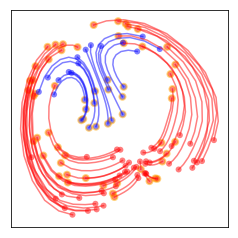

In [320]:
from viz.plots import trajectory_plt

# To make the plot clearer, we will use a smaller batch of data
for small_inputs, small_targets in dataloader:
    break

trajectory_plt(model2, small_inputs, small_targets, timesteps=10)

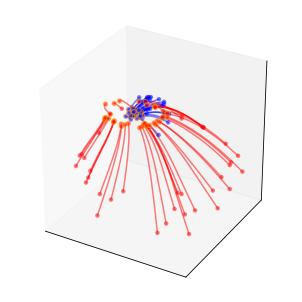

In [319]:


trajectory_plt(amodel2, small_inputs, small_targets, timesteps=10)

# Lyapunov NODE At Time 0

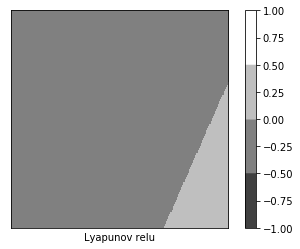

In [297]:
lyapunov_plot(model,time=0)



# Lyapunov ANODE At Time 0

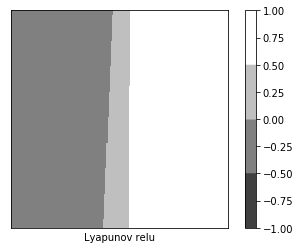

In [276]:
lyapunov_plot(amodel,time=0)



# Lyapunov NODE(level 2 ODE function) At Time 0

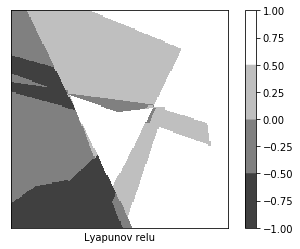

In [303]:
lyapunov_plot(model2,time=0)



# Lyapunov NODE(level 2 ODE function) At Final Time

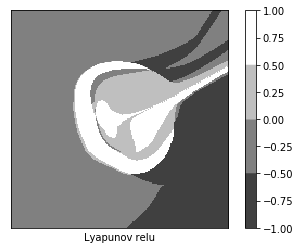

In [311]:
lyapunov_plot(model2,time=9)



# Lyapunov ANODE(level 2 ODE function) At Initial Time

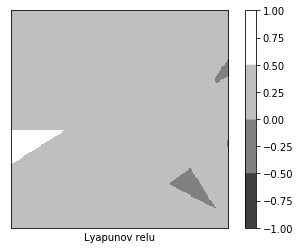

In [269]:
lyapunov_plot(amodel2,time=0)



# Lyapunov ANODE(level 2 ODE function) At Final Time

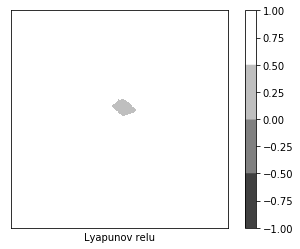

In [312]:
lyapunov_plot(amodel2,time=9)



# NODE
train a Node network with level 2

$Level\ 2:\ f(x,\theta)= W_2\sigma (W_1X+b_1)+b_2 $

In [313]:
num_epochs = 24
model = ODENet(device, data_dim, hidden_dim, time_dependent=False,level=1,
               non_linearity='relu',final_time=1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model, optimizer, device,verbose=False)
trainer.train(dataloader,test_inputs, test_targets,num_epochs)

In [300]:
num_epochs = 24
model2 = ODENet(device, data_dim, hidden_dim, time_dependent=False,level=2,
               non_linearity='relu',final_time=1)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

trainer2 = Trainer(model2, optimizer2, device,verbose=False)
trainer2.train(dataloader,test_inputs, test_targets,num_epochs)

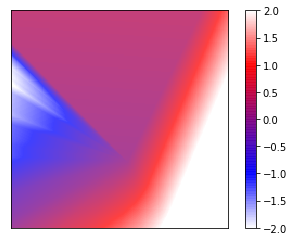

In [314]:
input_space_plt(model)

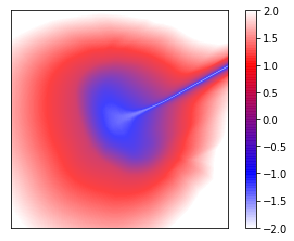

In [301]:
input_space_plt(model2)

# Anode
train a Anode network with level 2, augment dimension = 1


In [315]:
amodel = ODENet(device, data_dim, hidden_dim, time_dependent=False,level=1,augment_dim=1,
               non_linearity='relu',final_time=1)

aoptimizer = torch.optim.Adam(amodel.parameters(), lr=1e-3)

atrainer = Trainer(amodel, aoptimizer, device,verbose=False)
atrainer.train(dataloader,test_inputs, test_targets,num_epochs)

In [309]:
amodel2 = ODENet(device, data_dim, hidden_dim, time_dependent=False,level=2,augment_dim=1,
               non_linearity='relu',final_time=1)

aoptimizer2 = torch.optim.Adam(amodel2.parameters(), lr=1e-3)

atrainer2 = Trainer(amodel2, aoptimizer2, device,verbose=False)
atrainer2.train(dataloader,test_inputs, test_targets,num_epochs)

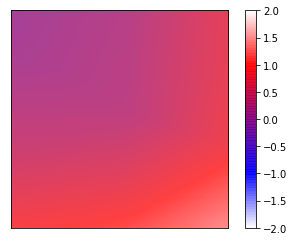

In [316]:
input_space_plt(amodel)

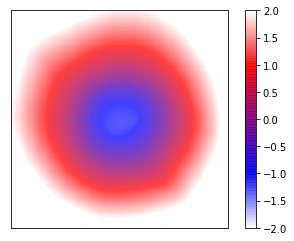

In [310]:
input_space_plt(amodel2)